<a href="https://colab.research.google.com/github/EugOT/compneuro/blob/main/notebooks/2024-11-12_Linear-dynamic-system.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a> &nbsp; <a href="https://kaggle.com/kernels/welcome?src=https://raw.githubusercontent.com/EugOT/compneuro/main/notebooks/2024-11-12_Linear-dynamic-system.ipynb" target="_parent"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" alt="Open in Kaggle"/></a>

# Linear dynamical systems

---
# Tutorial Objectives

In this tutorial, we will be learning about behavior of dynamical systems -- systems that evolve in time -- where the rules by which they evolve in time are described precisely by a differential equation.

Differential equations are equations that express the **rate of change** of the state variable $x$. One typically describes this rate of change using the derivative of $x$ with respect to time ($dx/dt$) on the left hand side of the differential equation:

$$\frac{dx}{dt} = f(x)$$

A common notational short-hand is to write $\dot{x}$ for $\frac{dx}{dt}$. The dot means "the derivative with respect to time".

Today, the focus will be on **linear dynamics**, where $f(x)$ is a linear function of $x$. In Tutorial 1, we will:

* Explore and understand the behavior of such systems where $x$ is a single variable
* Consider cases where $\mathbf{x}$ is a state vector representing two variables.


---
# Setup

In [31]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp  # numerical integration solver

In [32]:
#@title Figure settings
import ipywidgets as widgets       # interactive display
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/nma.mplstyle")

In [33]:
#@title Helper functions
def plot_trajectory(system, params, initial_condition, dt=0.1, T=6,
                    figtitle=None):

    """
    Shows the solution of a linear system with two variables in 3 plots.
    The first plot shows x1 over time. The second plot shows x2 over time.
    The third plot shows x1 and x2 in a phase portrait.

    Args:
      system (function): a function f(x) that computes a derivative from
                         inputs (t, [x1, x2], *params)
      params (list or tuple): list of parameters for function "system"
      initial_condition (list or array): initial condition x0
      dt (float): time step of simulation
      T (float): end time of simulation
      figtitlte (string): title for the figure

    Returns:
      nothing, but it shows a figure
    """

    # time points for which we want to evaluate solutions
    t = np.arange(0, T, dt)

    # Integrate
    # use built-in ode solver
    solution = solve_ivp(system,
                     t_span=(0, T),
                     y0=initial_condition, t_eval=t,
                     args=(params),
                     dense_output=True)
    x = solution.y

    # make a color map to visualize time
    timecolors = np.array([(1 , 0 , 0, i)  for i in t / t[-1]])

    # make a large figure
    fig, (ah1, ah2, ah3) = plt.subplots(1, 3)
    fig.set_size_inches(10, 3)

    # plot x1 as a function of time
    ah1.scatter(t, x[0,], color=timecolors)
    ah1.set_xlabel('time')
    ah1.set_ylabel('x1', labelpad=-5)

    # plot x2 as a function of time
    ah2.scatter(t, x[1], color=timecolors)
    ah2.set_xlabel('time')
    ah2.set_ylabel('x2', labelpad=-5)

    # plot x1 and x2 in a phase portrait
    ah3.scatter(x[0,], x[1,], color=timecolors)
    ah3.set_xlabel('x1')
    ah3.set_ylabel('x2', labelpad=-5)
    #include initial condition is a blue cross
    ah3.plot(x[0,0], x[1,0], 'bx')

    # adjust spacing between subplots
    plt.subplots_adjust(wspace=0.5)

    # add figure title
    if figtitle is not None:
      fig.suptitle(figtitle, size=16)


def plot_streamplot(A, ax, figtitle=None):
    """
    Show a stream plot for a linear ordinary differential equation with
    state vector x=[x1,x2] in axis ax.

    Args:
      A (numpy array): 2x2 matrix specifying the dynamical system
      figtitle (string): title for the figure

    Returns:
      nothing, but shows a figure
    """

    # sample 20 x 20 grid uniformly to get x1 and x2
    grid = np.arange(-20, 21, 1)
    x1, x2 = np.meshgrid(grid, grid)

    # calculate x1dot and x2dot at each grid point
    x1dot = A[0,0] * x1 + A[0,1] * x2
    x2dot = A[1,0] * x1 + A[1,1] * x2

    # make a colormap
    magnitude = np.sqrt(x1dot ** 2 + x2dot ** 2)
    color = 2 * np.log1p(magnitude) #Avoid taking log of zero

    # plot
    plt.sca(ax)
    plt.streamplot(x1, x2, x1dot, x2dot, color=color,
                   linewidth=1, cmap=plt.cm.cividis,
                   density=2, arrowstyle='->', arrowsize=1.5)
    plt.xlabel(r'$x1$')
    plt.ylabel(r'$x2$')

    # figure title
    if figtitle is not None:
        plt.title(figtitle, size=16)

    # include eigenvectors
    if True:
        # get eigenvalues and eigenvectors of A
        lam, v = np.linalg.eig(A)

        # get eigenvectors of A
        eigenvector1 = v[:,0].real
        eigenvector2 = v[:,1].real

        # plot eigenvectors
        plt.arrow(0, 0, 20*eigenvector1[0], 20*eigenvector1[1],
                  width=0.5, color='r', head_width=2,
                  length_includes_head=True)
        plt.arrow(0, 0, 20*eigenvector2[0], 20*eigenvector2[1],
                  width=0.5, color='b', head_width=2,
                  length_includes_head=True)

def plot_specific_example_stream_plots(A_options):
    """
    Show a stream plot for each A in A_options

    Args:
      A (list): a list of numpy arrays (each element is A)

    Returns:
      nothing, but shows a figure
    """
    # get stream plots for the four different systems
    plt.figure(figsize=(10,10))

    for i, A in enumerate(A_options):

        ax = plt.subplot(2, 2, 1+i)
        # get eigenvalues and eigenvectors
        lam, v = np.linalg.eig(A)

        # plot eigenvalues as title
        # (two spaces looks better than one)
        eigstr = ",  ".join([f"{x:.2f}" for x in lam])
        figtitle =f"A with eigenvalues\n"+ '[' + eigstr + ']'
        plot_streamplot(A, ax, figtitle=figtitle)

        # Remove y_labels on righthand plots
        if i%2:
          ax.set_ylabel(None)
        if i<2:
          ax.set_xlabel(None)

        plt.subplots_adjust(wspace=0.3, hspace=0.3)

---
# Section 1: One-dimensional Differential Equations



Let's start by reminding ourselves of a one-dimensional differential equation in $x$ of the form

$$\dot{x} = a x$$

where $a$ is a scalar.

Solutions for how $x$ evolves in time when its dynamics are governed by such a differential equation take the form

$$x(t) = x_0\exp(a t)$$

where $x_0$ is the **initial condition** of the equation -- that is, the value of $x$ at time $0$.

To gain further intuition, let's explore the behavior of such systems with a simple simulation. We can simulate an ordinary differential equation by approximating or modelling time as a discrete list of time steps $t_0, t_1, t_2, \dots$, such that $t_{i+1}=t_i+dt$. We can get the small change $dx$ over a small duration $dt$ of time from the definition of the differential:

$$ \
\begin{eqnarray}
  \dot x &=& \frac{dx}{dt} \\
  dx     &=& \dot x\, dt  \\
\end{eqnarray}
$$

So, at each time step $t_i$, we compute a value of $x$, $x(t_i)$, as the sum of the value of $x$ at the previous time step, $x(t_{i-1})$ and a small change $dx=\dot x\,dt$:

$$x(t_i)=x(t_{i-1})+\dot x(t_{i-1}) dt$$

This very simple integration scheme, known as **forward Euler integration**, works well if $dt$ is small and the ordinary differential equation is simple. It can run into issues when the ordinary differential equation is very noisy or when the dynamics include sudden big changes of $x$. Such big jumps can occur, for example, in models of excitable neurons. In such cases, one needs to choose an integration scheme carefully. However, for our simple system, the simple integration scheme should work just fine!


## Exercise 1 (1A): Forward Euler Integration

In this exercise, we will complete a function, ``integrate_exponential``, to compute the solution of the differential equation $\dot{x} = a x$ using forward Euler integration. We will then plot this solution over time.





findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font fam

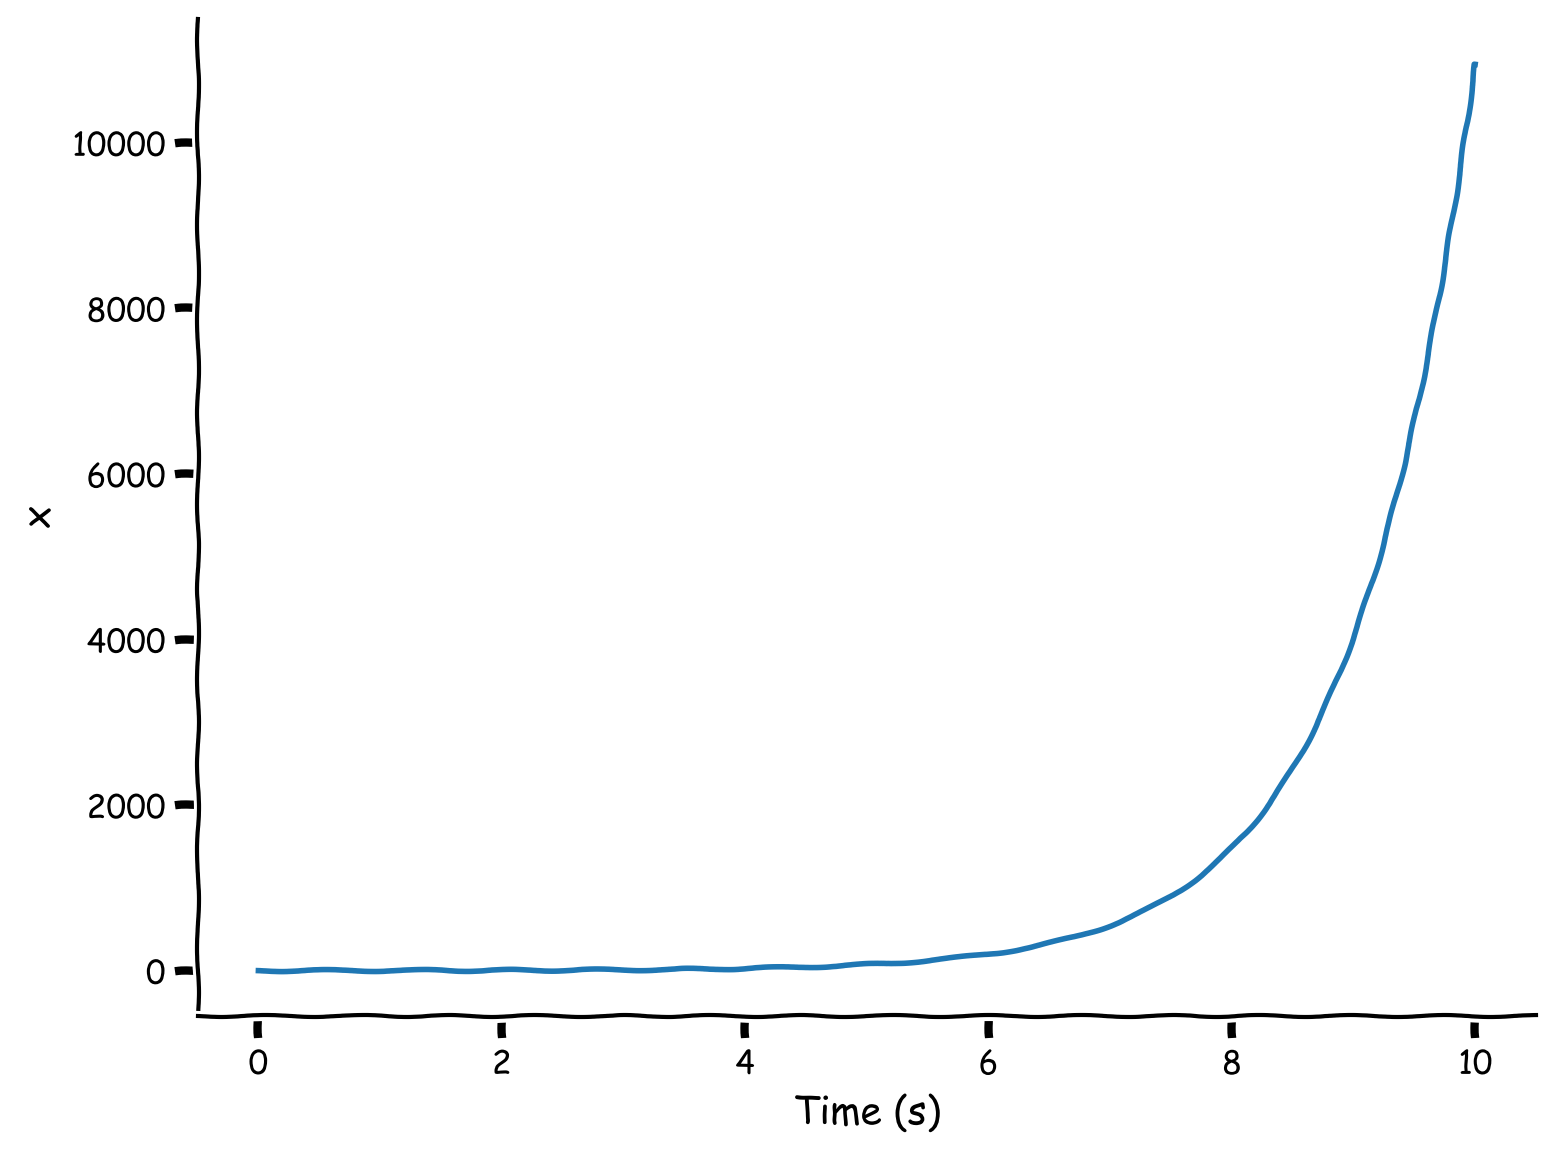

In [34]:
def integrate_exponential(a, x0, dt, T):
  """Compute solution of the differential equation xdot=a*x with
  initial condition x0 for a duration T. Use time step dt for numerical
  solution.

  Args:
    a (scalar): parameter of xdot (xdot=a*x)
    x0 (scalar): initial condition (x at time 0)
    dt (scalar): timestep of the simulation
    T (scalar): total duration of the simulation

  Returns:
    ndarray, ndarray: `x` for all simulation steps and the time `t` at each step
  """

  # Initialize variables
  t = np.arange(0, T, dt)
  x = np.zeros_like(t, dtype=complex)
  x[0] = x0 # This is x at time t_0

  # Step through system and integrate in time
  for k in range(1, len(t)):

    ###################################################################
    ## Fill out the following then remove
    ## raise NotImplementedError("Student exercise: need to implement simulation")
    ###################################################################

    # for each point in time, compute xdot from x[k-1]
    xdot = a + x[k-1]

    # Update x based on x[k-1] and xdot
    x[k] = x[k-1] + xdot * dt

  return x, t


# choose parameters
a = -0.5    # parameter in f(x)
T = 10      # total Time duration
dt = 0.001  # timestep of our simulation
x0 = 1.     # initial condition of x at time 0

# Uncomment once you've filled in code above
x, t = integrate_exponential(a, x0, dt, T)
with plt.xkcd():
    plt.plot(t, x.real)
    plt.xlabel('Time (s)')
    plt.ylabel('x')
    plt.show()

## Interactive Demo: Forward Euler Integration

 What happens when you change $a$? Try values where $a<0$ and $a>0$.

 The $dt$ is the step size of the forward Euler integration. Try $a = -1.5$ and increase $dt$. What happens to the numerical solution when you increase $dt$?

In [35]:
#@title

#@markdown Make sure you execute this cell to enable the widget!

T = 10      # total Time duration
x0 = 1.     # initial condition of x at time 0

@widgets.interact
def plot_euler_integration(a=(-2.5, 1.5, .25), dt = widgets.SelectionSlider(options=[("%g"%i,i) for i in np.arange(0.001, 1.001, 0.01)])):
  # Have to do this clunky word around to show small values in slider accurately
  # (from https://github.com/jupyter-widgets/ipywidgets/issues/259)

  x, t = integrate_exponential(a, x0, dt, T)
  plt.plot(t, x.real) # integrate_exponential returns complex
  plt.xlabel('Time (s)')
  plt.ylabel('x')
  plt.show()

interactive(children=(FloatSlider(value=-0.5, description='a', max=1.5, min=-2.5, step=0.25), SelectionSlider(…

---
# Section 2: Oscillatory Dynamics

We will now explore what happens when $a$ is a complex number and has a non-zero imaginary component.

## Interactive Demo: Oscillatory Dynamics
In the following demo, you can change the real part and imaginary part of $a$ (so a = real + imaginary i)


In [ ]:
#@title

#@markdown Make sure you execute this cell to enable the widget!

# parameters
T = 5         # total Time duration
dt = 0.0001      # timestep of our simulation
x0 = 1.        # initial condition of x at time 0

@widgets.interact
def plot_euler_integration(real=(-2, 2, .2), imaginary=(-4, 7, .1)):

  a = complex(real, imaginary)
  x, t = integrate_exponential(a, x0, dt, T)
  plt.plot(t, x.real) #integrate exponential returns complex
  plt.grid(True)
  plt.xlabel('Time (s)')
  plt.ylabel('x')
  plt.show()

## Exercise 2 (1B): Finding Oscillatory Solutions
Using the demo above, answer the following:
- What values of $a$ produce dynamics that both ***oscillate*** and ***grow***?
- What value of $a$ is needed to produce a stable oscillation of 0.5 Hertz (cycles/time units)?

---
# Section 3: Deterministic Linear Dynamics in Two Dimensions

Adding one additional variable (or _dimension_) adds more variety of behaviors. Additional variables are useful in modeling the dynamics of more complex systems with richer behaviors, such as systems of multiple neurons. We can write such a system using two linear ordinary differential equations:
$$
\begin{eqnarray}
  \dot{x}_1 &=& {a}_{11} x_1 \\
  \dot{x}_2 &=& {a}_{22} x_2 \\
\end{eqnarray}
$$
So far, this system consists of two variables (e.g. neurons) in isolation. To make things interesting, we can add interaction terms:
$$
\begin{eqnarray}
  \dot{x}_1 &=& {a}_{11} x_1 + {a}_{12} x_2 \\
  \dot{x}_2 &=& {a}_{21} x_1 + {a}_{22} x_2 \\
\end{eqnarray}
$$
We can write the two equations that describe our system as one (vector-valued) linear ordinary differential equation:

$$\dot{\mathbf{x}} = \mathbf{A} \mathbf{x}$$

For two-dimensional systems, $\mathbf{x}$ is a vector with 2 elements ($x_1$ and $x_2$) and $\mathbf{A}$ is a $2 \times 2$ matrix with $\mathbf{A}=\bigg[\begin{array} & a_{11} & a_{12} \\ a_{21} & a_{22} \end{array} \bigg]$.

## Exercise 3 (1C): Sample trajectories in 2 dimensions


We want to simulate some **trajectories** of a given system and plot how  𝑥1  and  𝑥2  evolve in time. We will begin with this example system:

$$\dot{\mathbf{x}} = \bigg[\begin{array} &2 & -5 \\ 1 & -2 \end{array} \bigg] \mathbf{x}$$

We will use an integrator from scipy, so we won't have to solve the system ourselves. We have a helper function, ``plot_trajectory``, that plots these trajectories given a system function. In this exercise, we will write the system function for a linear system with two variables.




In [25]:
def system(t, x, a00, a01, a10, a11):
    '''
    Compute the derivative of the state x at time t for a linear
    differential equation with A matrix [[a00, a01], [a10, a11]].

    Args:
      t (float): time
      x (ndarray): state variable
      a00, a01, a10, a11 (float): parameters of the system

    Returns:
      ndarray: derivative xdot of state variable x at time t
    '''
  #################################################
  ## TODO for students: Compute xdot1 and xdot2 ##
  ## Fill out the following then remove
  raise NotImplementedError("Student exercise: say what they should have done")
  #################################################

  # compute x1dot and x2dot
  x1dot = ...
  x2dot = ...

  return np.array([x1dot, x2dot])


T = 6 # total time duration
dt = 0.1 # timestep of our simulation
A = np.array([[2, -5],
              [1, -2]])
x0 = [-0.1, 0.2]

# Uncomment once the system function is complete
with plt.xkcd():
    plot_trajectory(system, [A[0,0],A[0,1],A[1,0],A[1,1]], x0, dt=dt, T=T)
    plt.show()

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 17)

## Interactive Demo: Varying A

We will now use the function we created in the last exercise to plot trajectories with different options for A. What kinds of qualitatively different dynamics do you observe? Hint: Keep an eye on the x-axis and y-axis!

In [ ]:
#@title

#@markdown Make sure you execute this cell to enable the widget!

# parameters
T = 6      # total Time duration
dt = 0.1   # timestep of our simulation
x0 = np.asarray([-0.1, 0.2])        # initial condition of x at time 0

A_option_1 = [[2, -5],[1, -2]]
A_option_2 = [[3,4], [1, 2]]
A_option_3 = [[-1, -1], [0, -0.25]]
A_option_4 = [[3, -2],[2, -2]]

@widgets.interact
def plot_euler_integration(A = widgets.Dropdown(
  options=[A_option_1, A_option_2, A_option_3, A_option_4, None],
  value=A_option_1
)):
  if A:
    plot_trajectory(system, [A[0][0],A[0][1],A[1][0],A[1][1]], x0, dt=dt, T=T)

## Interactive Demo: Varying Initial Conditions

We will now vary the initial conditions for a given $\mathbf{A}$:

$$\dot{\mathbf{x}} = \bigg[\begin{array} &2 & -5 \\ 1 & -2 \end{array} \bigg] \mathbf{x}$$

What kinds of qualitatively different dynamics do you observe? Hint: Keep an eye on the x-axis and y-axis!

In [ ]:
#@title

#@markdown Make sure you execute this cell to enable the widget!

# parameters
T = 6      # total Time duration
dt = 0.1   # timestep of our simulation
x0 = np.asarray([-0.1, 0.2])        # initial condition of x at time 0
A = [[2, -5],[1, -2]]

x0_option_1 = [-.1, 0.2]
x0_option_2 = [10, 10]
x0_option_3 = [-4, 3]

@widgets.interact
def plot_euler_integration(x0 = widgets.Dropdown(
  options=[x0_option_1, x0_option_2, x0_option_3, None],
  value=x0_option_1
)):
  if x0:
    plot_trajectory(system, [A[0][0],A[0][1],A[1][0],A[1][1]], x0, dt=dt, T=T)

---
# Section 4: Stream Plots

It's a bit tedious to plot trajectories one initial condition at a time!

Fortunately, to get an overview of how a grid of initial conditions affect trajectories of a system, we can use a _stream plot_.

We can think of a initial condition ${\bf x}_0=(x_{1_0},x_{2_0})$  as coordinates for a position in a space. For a 2x2 matrix $\bf A$, a stream plot computes at each position $\bf x$ a small arrow that indicates $\bf Ax$ and then connects the small arrows to form _stream lines_. Remember from the beginning of this tutorial that $\dot {\bf x} = \bf Ax$ is the rate of change of $\bf x$. So the stream lines indicate how a system changes. If you are interested in a particular initial condition ${\bf x}_0$, just find the correponding position in the stream plot. The stream line that goes through that point in the stream plot indicates ${\bf x}(t)$.

Using some helper functions, we show the stream plots for each option of A that you examined in the earlier interactive demo. We included the eigenvectors of $\bf A$ as a red line (1st eigenvalue) and a blue line (2nd eigenvalue) in the stream plots.


In [ ]:
A_option_1 = np.array([[2, -5.5], [1, -2.5]])
A_option_2 = np.array([[3,4], [1, 2]])
A_option_3 = np.array([[-1, -1], [0, -0.25]])
A_option_4 = np.array([[3, -2], [2, -2]])

A_options = [A_option_1, A_option_2, A_option_3, A_option_4]
plot_specific_example_stream_plots(A_options)

### Think

What is special about the direction in which the principal eigenvector points? And how does the stability of the system relate to the corresponding eigenvalues? (Hint: Remember from linear algebra that, for matrices with real eigenvalues, the eigenvectors indicate the lines on which $\bf Ax$ is parallel to $\bf x$ and real eigenvalues indicate the factor by which $\bf Ax$ is streched or shrunk compared to $\bf x$.)

In [ ]:
#### Jot downs some thoughts here ###

---
# Summary

In this tutorial, we learned:

* How to simulate the trajectory of a dynamical system specified by a differential equation $\dot{x} = f(x)$ using a forward Euler integration scheme.
* The behavior of a one-dimensional linear dynamical system $\dot{x} = a x$ is determined by $a$, which may be a complex valued number. Knowing $a$, we know about the stability and oscillatory dynamics of the system.
* The dynamics of high-dimensional linear dynamical systems $\dot{\mathbf{x}} = \mathbf{A} \mathbf{x}$ can be understood using the same intuitions, where we can summarize the behavior of the trajectories using the eigenvalues and eigenvectors of $\mathbf{A}$.